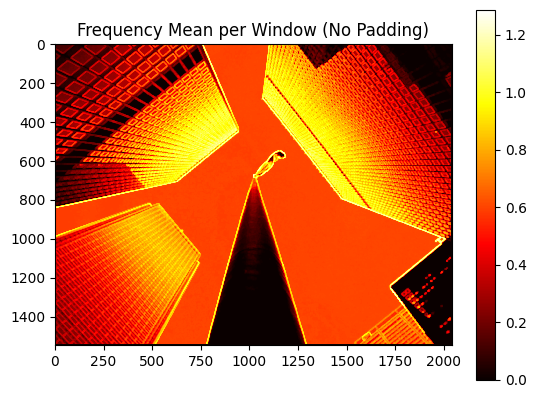

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from matplotlib.image import imread

# 加载图像
image = imread('/home/yinqiang/fourier-feature-networks/0188.png')
# 假设是灰度图像或只取一个通道进行演示
channel = image[:,:,0]  # 如果是彩色图像，这里以R通道为例

# 定义窗口大小和半窗口
window_size = 8
half_window = window_size // 2

# 初始化一个与原图像同尺寸的数组，用于存放每个窗口的频率均值
freq_means = np.zeros_like(channel, dtype=float)

# 计算可用于窗口中心的图像范围，以避免边缘外的窗口
x_range = range(half_window, channel.shape[0] - half_window)
y_range = range(half_window, channel.shape[1] - half_window)

for x in x_range:
    for y in y_range:
        # 提取以(x, y)为中心的窗口
        local_window = channel[x-half_window:x+half_window+1, y-half_window:y+half_window+1]

        # 计算窗口的FFT
        local_fft = fft2(local_window)

        # 计算FFT的幅度
        magnitude = np.abs(local_fft)

        # 计算幅度的均值，并赋值给中心像素位置
        freq_means[x, y] = np.mean(magnitude)

# 对频率均值进行对数转换以改善可视化效果
freq_means_log = np.log1p(freq_means)  # np.log1p等价于np.log(1 + x)，用于增加数值稳定性

# 绘制结果
plt.imshow(freq_means_log, cmap='hot', interpolation='nearest')
plt.title('Frequency Mean per Window (No Padding)')
plt.colorbar()
plt.show()


cuda


/tmp/ipykernel_2412460/2957984981.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)[..., :3] / 255.


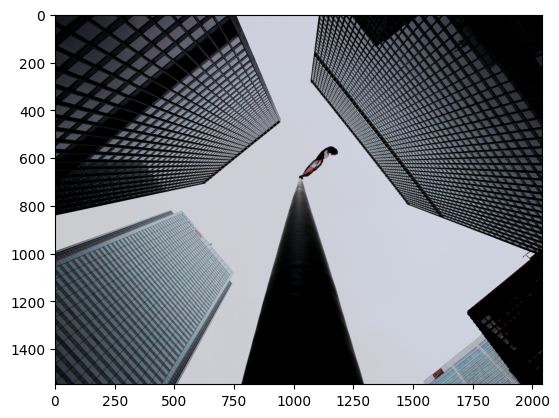

In [3]:
#@title Imports and Boilerplate

import urllib.request

import torch

import torch.nn as nn
import tqdm

import numpy as np
import cv2

import cv2
import imageio
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
from torch import nn
import matplotlib.pyplot as plt

def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor

def get_image():
    # image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
    # img = imageio.imread(image_url)[..., :3] / 255.
    # c = [img.shape[0] // 2, img.shape[1] // 2]
    # r = 256
    # img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]
    image_path = '/home/yinqiang/yzw/datasets/div_bad_25_100/0188.png'
    # Reading the image from the local filesystem
    img = imageio.imread(image_path)[..., :3] / 255.
    c = [img.shape[0]//2, img.shape[1]//2]
    r = 256
    #img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
    return img
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
def get_psnr(img, output):
    block_original = img
    block_processed = output
    psnr_value = psnr(block_original, block_processed, data_range=255)

    return psnr_value
def save_img(generated, save_dir):
    from torchvision.utils import save_image
    import os
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 保存图像，这里仅保存批量中的第一个图像作为示例
    save_path = os.path.join(save_dir, "generated_image.png")
    save_image(generated[0], save_path)

    print(f"Generated image saved to {save_path}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Get an image that will be the target for our model.
target = torch.tensor(get_image()).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(target[0]))
plt.show()

# Create input pixel coordinates in the unit square. This will be the input to the model.
coords_x = np.linspace(0, 1, target.shape[3], endpoint=False)
coords_y = np.linspace(0, 1, target.shape[2], endpoint=False)
xy_grid = np.stack(np.meshgrid(coords_x, coords_y), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

from math import log2
class Embedder(nn.Module):
    def __init__(self, num_freqs, scale):
        super(Embedder, self).__init__()
        self.num_freqs = num_freqs
        self.scale = scale
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = 2
        out_dim = 0
        if False:
            embed_fns.append(lambda x : x)
            out_dim += d
            
        max_freq = log2(self.scale)
        N_freqs = self.num_freqs
        

        freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)

        for freq in freq_bands:
            for p_fn in [torch.sin, torch.cos]:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(2*torch.pi* x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def forward(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], 1)

In [21]:
import torch
import torch.nn as nn
from math import log2

class PositionalEncoder(nn.Module):
    def __init__(self, num_freqs, freq_means_log):
        super(PositionalEncoder, self).__init__()
        self.num_freqs = num_freqs
        self.freq_means_log = freq_means_log

    def forward(self, inputs):
        # 假设inputs是一个N*2的tensor，其中N是点的数量，2代表x和y坐标
        print(inputs.shape)
        encoded = torch.zeros(1, self.num_freqs*4, inputs.shape[2], inputs.shape[3])

        for i in range(self.freq_means_log.shape[0]):
            for j in range(self.freq_means_log.shape[1]):
                embed_fns = []
                scale = 50 * self.freq_means_log[i, j]+1
                max_freq = log2(scale)
                N_freqs = self.num_freqs
                freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
                for freq in freq_bands:
                    for p_fn in [torch.sin, torch.cos]:
                        embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(2 * torch.pi * x * freq))

                encoded[0,:,i,j] = torch.cat([fn(inputs[0][:,i,j]) for fn in embed_fns])
        print("finished")        
        return encoded


In [22]:
model = nn.Sequential(
        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        # nn.Conv2d(
        #     256,
        #     256,
        #     kernel_size=1,
        #     padding=0),
        # nn.ReLU(),
        # nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            3,
            kernel_size=1,
            padding=0),
        nn.Sigmoid(),

    ).to(device)

# Note: this can be done outside of the training loop, since the result at this stage is unchanged during the course of training.
x = PositionalEncoder(64, freq_means_log)(xy_grid)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

for epoch in tqdm(range(10000)):
    optimizer.zero_grad()

    generated = model(x)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(tensor_to_numpy(target[0]))
      ax1.set_title('GT')  # 设置子图的标题
      ax2.imshow(tensor_to_numpy(generated[0]))
      ax2.set_title('Recon')  # 设置子图的标题
      
      plt.show()
      target_np = tensor_to_numpy(target[0])
      generated_np = tensor_to_numpy(generated[0])
      print("psnr for upper block is ", get_psnr(target_np[0:256, 0:256], generated_np[0:256, 0:256]))
      height, width, _ = target_np.shape
      print("psnr for lower block is ", get_psnr(target_np[height-256:height, width-256:width], generated_np[height-256:height, width-256:width]))  
      print("psnr for whole image is ", get_psnr(target_np, generated_np))
    if epoch == 9999:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(tensor_to_numpy(target[0]))
      ax1.set_title('GT')  # 设置子图的标题
      ax2.imshow(tensor_to_numpy(generated[0]))
      ax2.set_title('Recon')  # 设置子图的标题
      
      plt.show()
      target_np = tensor_to_numpy(target[0])
      generated_np = tensor_to_numpy(generated[0])
      print("psnr for upper block is ", get_psnr(target_np[0:256, 0:256], generated_np[0:256, 0:256]))
      height, width, _ = target_np.shape
      print("psnr for lower block is ", get_psnr(target_np[height-256:height, width-256:width], generated_np[height-256:height, width-256:width]))  
      print("psnr for whole image is ", get_psnr(target_np, generated_np))
      save_img(generated, save_dir = "/home/yinqiang/fourier-feature-networks/Result_188/PE_Len256/Layer4_Scale25")

torch.Size([1, 2, 1548, 2040])


KeyboardInterrupt: 